# Will a MLB free agent sign a multiyear contract? 
Comparing CART and Logistic Regression and see which stats will affect free agent signing

In [1]:
# Load modules
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from collections import Counter
pd.options.display.max_columns = None      # Show all columns in Jupyter notebook
pd.set_option('display.max_rows', 2000)    # Show all rows in Jupyter notebook

In [2]:
Batter = pd.read_csv("batter_final_df.csv")
Pitcher = pd.read_csv("pitcher_final_df.csv")
Batter.head()

,Name,Position,Age,From,To,Years,Dollars,Average_Salary,FA_year,bbrefID,Age_M1,Year,Age_prev,Tm,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,WAR,1B_accum,2B_accum,3B_accum,AB_accum,BA_accum,BB_accum,CS_accum,G_accum,GDP_accum,H_accum,HBP_accum,HR_accum,IBB_accum,OBP_accum,OPS_accum,PA_accum,R_accum,RBI_accum,SB_accum,SF_accum,SH_accum,SLG_accum,SO_accum,TB_accum,WAR_accum
0,Albert Pujols,DH,32,STL,LAA,10,240000000,24000000,2012,pujolal01,31,2011,31,STL,NL,147,651,579,105,173,29,0,37,99,9,1,61,58,0.299,0.366,0.541,0.906,148.0,313,29,4,0,7,15,5.3,1158.0,455.0,15.0,6312.0,0.328,975.0,35.0,1705.0,232.0,2073.0,77.0,445.0,251.0,0.420,1.037,7433.0,1291.0,1329.0,84.0,68.0,1.0,0.617,704.0,3893.0,86.6
1,Prince Fielder,DH,28,MIL,DET,9,214000000,23777778,2012,fieldpr01,27,2011,27,MIL,NL,162,692,569,95,170,36,1,38,120,1,1,107,106,0.299,0.415,0.566,0.981,164.0,322,17,10,0,6,32,4.5,557.0,200.0,9.0,3527.0,0.282,566.0,10.0,998.0,81.0,996.0,78.0,230.0,115.0,0.390,0.929,4210.0,571.0,656.0,16.0,39.0,0.0,0.540,779.0,1904.0,16.7
2,Jose Reyes,SS,29,NYM,MIA,6,106000000,17666667,2012,reyesjo01,28,2011,28,NYM,NL,126,586,537,101,181,31,16,7,44,39,7,43,41,0.337,0.384,0.493,0.877,144.0,265,5,0,2,4,9,4.6,898.0,222.0,99.0,4453.0,0.292,333.0,92.0,1050.0,45.0,1300.0,7.0,81.0,41.0,0.341,0.782,4840.0,735.0,423.0,370.0,19.0,28.0,0.441,509.0,1963.0,28.0
3,Aramis Ramirez,3B,34,CHC,MIL,3,36000000,12000000,2012,ramirar01,33,2011,33,CHC,NL,149,626,565,80,173,35,1,26,93,1,1,43,69,0.306,0.361,0.510,0.871,136.0,288,12,10,0,8,5,-0.7,1081.0,373.0,19.0,6293.0,0.284,501.0,15.0,1683.0,170.0,1788.0,89.0,315.0,50.0,0.342,0.842,6958.0,873.0,1122.0,16.0,72.0,3.0,0.500,958.0,3144.0,22.7
4,Michael Cuddyer,LF,33,MIN,COL,3,31500000,10500000,2012,cuddymi01,32,2011,32,MIN,AL,139,584,529,70,150,29,2,20,70,11,1,48,95,0.284,0.346,0.459,0.805,120.0,243,18,4,0,3,3,2.3,691.0,239.0,35.0,4072.0,0.272,411.0,16.0,1139.0,140.0,1106.0,43.0,141.0,30.0,0.343,0.794,4555.0,606.0,580.0,52.0,25.0,4.0,0.451,805.0,1838.0,12.9


# EDA

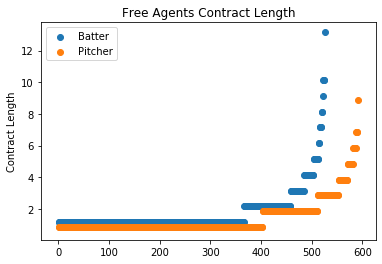

In [3]:
x_b = np.linspace(1, len(Batter["Years"]), len(Batter["Years"]))
plt.scatter(x_b, Batter["Years"].sort_values() + 0.15, label = "Batter")
x_p = np.linspace(1, len(Pitcher["Years"]), len(Pitcher["Years"]))
plt.scatter(x_p, Pitcher["Years"].sort_values() - 0.15, label = "Pitcher")
plt.ylabel("Contract Length")
# plt.yticks(ticks = np.linspace(0, 300000000, 7), labels = ["0", "50M", "100M", "150M", "200M", "250M", "300M"])
plt.title("Free Agents Contract Length")
plt.legend()

In [4]:
# Player with multiple year contract is 1
# Player with one year contract is 0
multiple_years = []
for i in Batter["Years"]:
    if i == 1:
        multiple_years.append(0)
    else:
        multiple_years.append(1)
Batter["Multiyear"] = multiple_years        
all_features_b = ['Age', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB',
       'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP',
       'SH', 'SF', 'IBB', 'WAR', 'G_accum', 'PA_accum', 'AB_accum', 'R_accum',
       'H_accum', '2B_accum', '3B_accum', 'HR_accum', 'RBI_accum', 'SB_accum',
       'CS_accum', 'BB_accum', 'SO_accum', 'BA_accum', 'OBP_accum',
       'SLG_accum', 'OPS_accum', 'TB_accum', 'GDP_accum', 'HBP_accum',
       'SH_accum', 'SF_accum', '1B_accum', 'WAR_accum']

I try to retain all the varaibles and these are the common statistics we see to evaluate a hitter. Metrics with out the suffix \_accum are the stats from the previous season (the season before the players enter free agency). The suffix \_accum represents the accumulative stats over a player's career. 
- G: Games played
- PA: Plate Appearance. Number of times a player comes to the plate
- AB: At-bat. Excludes sacrifice situations from PA
- R: Runs scored
- H: Hits
- 2B: Doubles
- 3B: Triples
- HR: Home runs 
- RBI: Runs Batted In
- SB: Stolen Base
- CS: Caught Stealing
- BB: Base on Balls
- SO: Stike Outs
- BA: Batting Averages
- OBP: On Base Percentage
- SLG: Slugging Percentage
- OPS: On base percentage Plus Slugging percentage
- OPS+: A player's OBP normalized to the entire league average (100). 100+ means you hit above league average
- TB: Total Bases
- GDP: Ground infield Double Play
- HBP: Hit By Pitch
- SH: Sacrifice Hit (Bunt)
- SF: Sacrifice Fly
- IBB: Intentional Base on Balls
- WAR: Win Above Replacement. <br>


According to MLB.com: WAR measures a player's value in all facets of the game by deciphering how many more wins he's worth than a replacement-level player at his same position. It is a commonly used metric to evaluate how good a player is overall. 

All the stats are web scraped from [baseball-reference.com](https://www.baseball-reference.com/).  <br>
You can see how I web scraped the data using BeautifulSoup [here](https://github.com/IanChuang/MLB_Free_Agent/blob/master/Web%20Scrape%20FA%20stats%20from%20Baseball%20Reference.ipynb).

In [5]:
X = Batter[all_features_b]
y = Batter["Multiyear"]
X_train, X_test, y_train, y_test  =  train_test_split(X,y, test_size = 0.2, random_state = 1)

In [6]:
# Baseline accuracy
print("Baseline accuracy is {:.2%}".format(np.mean(y_train == 0)))
print(Counter(multiple_years))

Baseline accuracy is 69.29%
Counter({0: 366, 1: 160})


We define players signing a multiple year contract as 1 (a "success") and signing a one-year contract a 0.  <br> 

Among all the free agent batters, 160 players signed multi-year contracts while 366 players signed one year deals.    <br>
Since most of the players are signing one-year contracts, the baseline model will be predicting every player to sign a one year contract and the baseline accuracy is around 69.29%. If we build a model that does not beat the baseline model, then the model would not be that useful. 

# CART (Classification and Regression Trees)

In [7]:
from sklearn import tree

clf_CART = tree.DecisionTreeClassifier(random_state = 1)
clf_CART = clf_CART.fit(X_train, y_train)
y_pred_CART = clf_CART.predict(X_test)
y_pred_CART_train = clf_CART.predict(X_train)

from sklearn.metrics import confusion_matrix

cm_CART = confusion_matrix(y_true = y_test, y_pred = y_pred_CART, labels = [1,0])
acc_CART = (cm_CART[0][0] + cm_CART[1][1]) / sum(sum(cm_CART))
cm_CART_train = confusion_matrix(y_true = y_train, y_pred = y_pred_CART_train, labels = [1,0])
acc_CART_train = (cm_CART_train[0][0] + cm_CART_train[1][1]) / sum(sum(cm_CART_train))
print("CART Accuracy on the train set: {:.2%}".format(acc_CART_train))
print(cm_CART_train)
print("===========================================")
print("CART Accuracy on the test set: {:.2%}".format(acc_CART))
print(cm_CART)
print("===========================================")
print("Baseline accuracy is {0:.2%}".format(1 - np.mean(y_train)))
print("===========================================")

from tabulate import tabulate
print(tabulate([['', "", 'Predicted', 'Predicted'], ['','', "2+ years", "1 year"], ['Actual',"2+ years", "True Positive", "True Negative"], ['Actual', '1 year', 'False Positive', 'True Negative']]))

CART Accuracy on the train set: 100.00%
[[129   0]
 [  0 291]]
CART Accuracy on the test set: 66.04%
[[13 18]
 [18 57]]
Baseline accuracy is 69.29%
------  --------  --------------  -------------
                  Predicted       Predicted
                  2+ years        1 year
Actual  2+ years  True Positive   True Negative
Actual  1 year    False Positive  True Negative
------  --------  --------------  -------------


If we don't set any parameters in the Tree Classifier, it would overfit the data, as the model will try its best to fit the training data. We see that the accuracy on the training set is 100%. This model fits perfectly to the training set (low bias) but performs worse than the baseline model (69%) where we predict every player to sign a one year contract (high variance). This is a perfect example of overfitting.   <br/>

There are a few ways to control for overfitting using CART, such as setting max_depth (how deep can the Tree grow), min_samples_split (the minimum number of samples required to split), and min_samples_leaf (the minimum number of samples at the bottom of the tree). 

We could set max_depth to control how deep the Tree grows, and see what depth has the highest test accuracy.

## Test accuracy at different depth

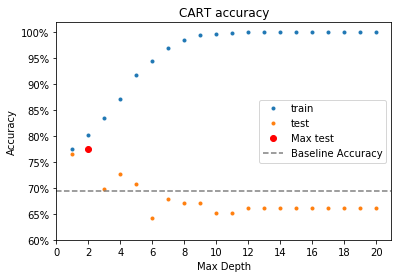

In [8]:
X = Batter[all_features_b]
y = Batter["Multiyear"]
X_train, X_test, y_train, y_test  =  train_test_split(X,y, test_size = 0.2, random_state = 1)

from sklearn import tree
from sklearn.metrics import confusion_matrix

train_acc = []
test_acc  = []

for i in range(1, 21): 
    clf_CART = tree.DecisionTreeClassifier(max_depth = i, random_state = 1)
    clf_CART = clf_CART.fit(X_train, y_train)
    y_pred_CART = clf_CART.predict(X_test)
    y_pred_CART_train = clf_CART.predict(X_train)

    cm_CART = confusion_matrix(y_test, y_pred_CART)
    acc_CART = (cm_CART[0][0] + cm_CART[1][1]) / sum(sum(cm_CART))
    cm_CART_train = confusion_matrix(y_train, y_pred_CART_train)
    acc_CART_train = (cm_CART_train[0][0] + cm_CART_train[1][1]) / sum(sum(cm_CART_train))
    train_acc.append(acc_CART_train)
    test_acc.append(acc_CART)
  
plt.plot(np.linspace(1,20,20), train_acc, '.', label = "train")
plt.plot(np.linspace(1,20,20), test_acc, '.',  label = "test")
plt.plot(test_acc.index(max(test_acc)) + 1, max(test_acc), "o", color = "red", label = "Max test")
plt.xticks(ticks = np.linspace(0, 20, 11))
plt.yticks(ticks = np.linspace(0.6, 1, 9), labels = ["{0:.0%}".format(i) for i in np.linspace(0.6, 1, 9)])
plt.axhline(y = (1 - np.mean(y_train)), ls = "--", label = "Baseline Accuracy", c = "grey")  # Basic Train accuracy 
plt.title("CART accuracy")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend()

From the plot above we can see that as the depth of the tree increases, the training accuracy goes to 100%. However, the test accuracy does not increase as depth increases, but levels out at around 66%. In this model, the test accuracy peaks at Depth = 2. However, the randomness of the train test split will effect how the model performs on the test set.

## Set max_depth = 2

In [9]:
X = Batter[all_features_b]
y = Batter["Multiyear"]
X_train, X_test, y_train, y_test  =  train_test_split(X,y, test_size = 0.2, random_state = 1)

from sklearn import tree

clf_CART = tree.DecisionTreeClassifier(random_state = 1, max_depth = 2)
clf_CART = clf_CART.fit(X_train, y_train)
y_pred_CART = clf_CART.predict(X_test)
y_pred_CART_train = clf_CART.predict(X_train)

from sklearn.metrics import confusion_matrix

cm_CART = confusion_matrix(y_true = y_test, y_pred = y_pred_CART, labels = [1,0])
acc_CART = (cm_CART[0][0] + cm_CART[1][1]) / sum(sum(cm_CART))
cm_CART_train = confusion_matrix(y_true = y_train, y_pred = y_pred_CART_train, labels = [1,0])
acc_CART_train = (cm_CART_train[0][0] + cm_CART_train[1][1]) / sum(sum(cm_CART_train))
print("CART Model using max_depth = 2")
print("===========================================")
print("CART Accuracy on the train set: {:.2%}".format(acc_CART_train))
print(cm_CART_train)
print("===========================================")
print("CART Accuracy on the test set: {:.2%}".format(acc_CART))
print(cm_CART)
print("===========================================")
print("Baseline accuracy is {0:.2%}".format(1 - np.mean(y_train)))
print("===========================================")

from tabulate import tabulate
print(tabulate([['', "", 'Predicted', 'Predicted'], ['','', "2+ years", "1 year"], ['Actual',"2+ years", "True Positive", "True Negative"], ['Actual', '1 year', 'False Positive', 'True Negative']]))

CART Model using max_depth = 2
CART Accuracy on the train set: 80.24%
[[ 60  69]
 [ 14 277]]
CART Accuracy on the test set: 77.36%
[[12 19]
 [ 5 70]]
Baseline accuracy is 69.29%
------  --------  --------------  -------------
                  Predicted       Predicted
                  2+ years        1 year
Actual  2+ years  True Positive   True Negative
Actual  1 year    False Positive  True Negative
------  --------  --------------  -------------


When we set max_depth = 2, even though the accuracy on the train set decreases, the test accuracy on the test set increases from 66.04% to 77.36%! <br>
However, the test accuracy is dependent on the train test split, as we can see from the plot below, the "best" depth varies as we use a different train test split. But however the data splits, the CART model seems to perform better than the baseline model, which is a great news.

## Tree with depth = 2

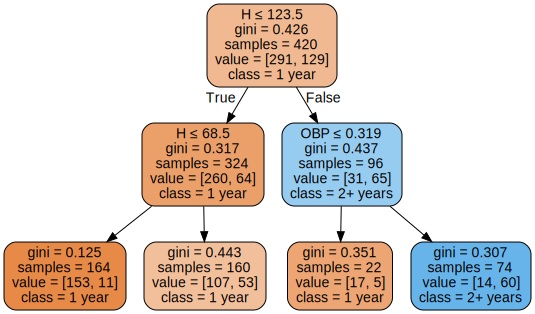

In [10]:
import graphviz 
dot_data = tree.export_graphviz(clf_CART, out_file=None, 
                                feature_names=all_features_b,  
                                class_names=["1 year", "2+ years"],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [11]:
# Variable used in tree when max_depth = 2
np.array(all_features_b)[[i for i, x in enumerate(clf_CART.feature_importances_) if x]]

array(['H', 'OBP'], dtype='<U9')

With a depth of 2, this tree uses only two variables: H and OBP.   <br>
When interpreting a tree, we have to look top down. If a player has fewer than or equal to 123 hits in the previous season, the model will predict that player will only sign a one year contract. If a player hits more than 123 hits and has a on-base percentage over .319 in the previous season, then the model will predict the player to sign a multiyear deal. The variables pick on the top is more important the variables pick in the lower layers.  <br>
This seems fairly reasonable, however, there are too little information that we can get from this model. So I ask myself, "Is this really the best model?" 

# How train test split affects test accuarcy

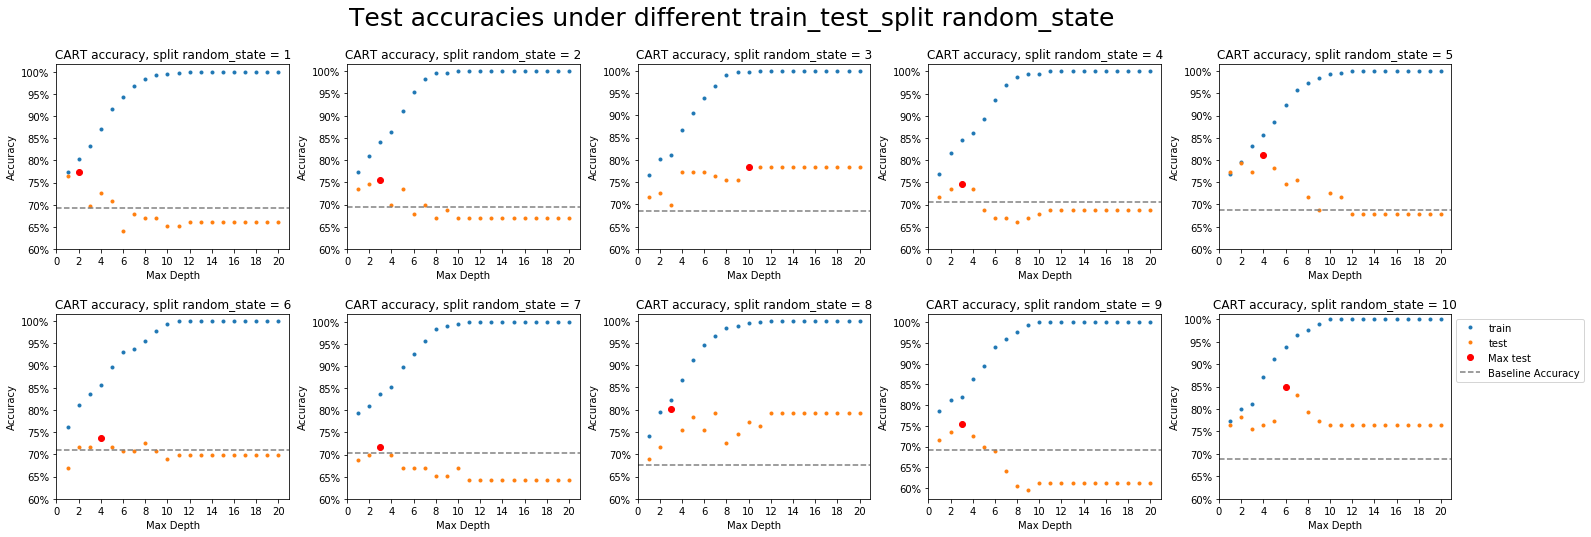

In [12]:
fig, ax = plt.subplots(nrows = 2,ncols = 5,figsize=(25,8))
fig.suptitle(t = "Test accuracies under different train_test_split random_state", fontsize = 25)
plt.subplots_adjust(hspace = 0.35, wspace = 0.25)
for k in range(10):    
    X = Batter[all_features_b]
    y = Batter["Multiyear"]
    X_train, X_test, y_train, y_test  =  train_test_split(X,y, test_size = 0.2, random_state = k+1)

    train_acc = []
    test_acc  = []

    for i in range(1, 21): 
        clf_CART = tree.DecisionTreeClassifier(max_depth = i, random_state = 1)
        clf_CART = clf_CART.fit(X_train, y_train)
        y_pred_CART = clf_CART.predict(X_test)
        y_pred_CART_train = clf_CART.predict(X_train)

        cm_CART = confusion_matrix(y_test, y_pred_CART)
        acc_CART = (cm_CART[0][0] + cm_CART[1][1]) / sum(sum(cm_CART))
        cm_CART_train = confusion_matrix(y_train, y_pred_CART_train)
        acc_CART_train = (cm_CART_train[0][0] + cm_CART_train[1][1]) / sum(sum(cm_CART_train))
        train_acc.append(acc_CART_train)
        test_acc.append(acc_CART)

    plt.subplot(2, 5, k+1)

    plt.plot(np.linspace(1,20,20), train_acc, '.', label = "train")
    plt.plot(np.linspace(1,20,20), test_acc, '.',  label = "test")
    plt.plot(test_acc.index(max(test_acc)) + 1, max(test_acc), "o", color = "red", label = "Max test")
    plt.xticks(ticks = np.linspace(0, 20, 11))
    plt.yticks(ticks = np.linspace(0.6, 1, 9), labels = ["{0:.0%}".format(i) for i in np.linspace(0.6, 1, 9)])
    plt.axhline(y = (1 - np.mean(y_train)), ls = "--", label = "Baseline Accuracy", c = "grey")  # Basic Train accuracy 
    plt.title("CART accuracy, split random_state = {}".format(k+1))
    plt.xlabel("Max Depth")
    plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1, 1))

Each plot shows the train accuracies and test accuracies under different max_depth. In most cases, the accuracies level around depth = 10. This is where the tree stops splitting. The 10 plots as a whole shows that accuracy changes under different splits. As the train test split changes, not only does the test accuracies vary, the optimal depth of the tree also vary. The best depth depend on which train/test split we picked. To find the "best" depth, we need to use cross validation.

# Cross Validation: K-fold cross validation

In k-fold, we split the data into k equivalent pieces (or folds). We hold one fold as the test set and using the rest as the training set. We run the model and record the accuracy and the parameters (in this case, max_depth) it uses. Then we select another fold as the test set, take the remaining folds as training set, and re-run the model and record the parameters. We do this k times and we will get a mean accuracy and the record of best parameters. By doing cross validation, we will have a better estimate of the test accuracy and the parameters.

k is often set to 5 or 10, and in this project, I will use 10 folds. 

Counter({2: 5, 4: 2, 8: 1, 10: 1, 5: 1})
Max 10-fold accuracy is 75.65% at depth = 2


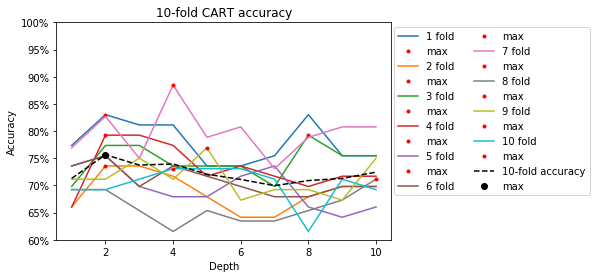

In [13]:
from sklearn.model_selection import KFold
k = 10   # k-fold
d = 10   # Max Depth
kf = KFold(n_splits=k, shuffle = True, random_state = 1)
kf.get_n_splits(X)
fold_train_acc = []
fold_test_acc = []
train_acc = []
test_acc  = []
max_depth = []
for train_index, test_index in kf.split(X):                  # Each loop is a fold
    for i in range(1, d+1):                                  # Each loop uses a different max_depth
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]

        clf_CART = tree.DecisionTreeClassifier(max_depth = i, random_state = 1)
        clf_CART = clf_CART.fit(X_train, y_train)
        y_pred_CART = clf_CART.predict(X_test)
        y_pred_CART_train = clf_CART.predict(X_train)

        cm_CART = confusion_matrix(y_test, y_pred_CART)
        acc_CART = (cm_CART[0][0] + cm_CART[1][1]) / sum(sum(cm_CART))
        cm_CART_train = confusion_matrix(y_train, y_pred_CART_train)
        acc_CART_train = (cm_CART_train[0][0] + cm_CART_train[1][1]) / sum(sum(cm_CART_train))
        train_acc.append(round(acc_CART_train, 4))
        test_acc.append(round(acc_CART, 4))
    fold_train_acc.append(train_acc)
    fold_test_acc.append(test_acc)
    train_acc = []
    test_acc  = []

test_acc_df = pd.DataFrame(fold_test_acc)        # Record all the accuracies under different depth in different folds

for i in range(k):
    row = test_acc_df.loc[i,:].tolist()
    plt.plot(np.linspace(1, d, d), row, label = "{} fold".format(i+1))
    plt.plot(row.index(max(row))+1, max(row), ".", color = "red", label = "max")
    max_depth.append(row.index(max(row))+1)
    
depth_mean_acc = test_acc_df.mean(axis = 0)
plt.plot(np.linspace(1, d, d), depth_mean_acc, "--", label = "10-fold accuracy", color ="black")
plt.plot(depth_mean_acc.tolist().index(max(depth_mean_acc))+1, max(depth_mean_acc), "o" ,color = "black", label = "max")
plt.legend(loc = "upper center", ncol = 2, bbox_to_anchor=(1.3, 1))
plt.yticks(ticks = np.linspace(0.6, 1, 9), labels = ["{0:.0%}".format(i) for i in np.linspace(0.6, 1, 9)])
plt.title("{}-fold CART accuracy".format(k))
plt.xlabel("Depth")
plt.ylabel("Accuracy")

from collections import Counter
print(Counter(max_depth))
print("Max 10-fold accuracy is {:.2%} at depth = {}".format(max(depth_mean_acc), depth_mean_acc.tolist().index(max(depth_mean_acc))+1))

Each colored line is the result of each fold. It shows the accuracy at each depth for different folds. The dashed black line indicates the mean accuarcy of the ten folds at different depth. The dots represents the highest accuract at each fold.    <br/>

In the ten folds, five of them have the highest accuracy at depth = 2. There are two folds at depth = 4, and one at depth = 5, 8, and 10. The mean accuracy of the ten fold cross validation is also peaks at depth = 2. It seems like depth = 2 will give us the highest test accuracy   <br/>

Now let's look at the tree again:

CART Model using max_depth = 2
CART Accuracy on the train set: 80.24%
[[277  14]
 [ 69  60]]
CART Accuracy on the test set: 77.36%
[[70  5]
 [19 12]]
Baseline accuracy is 69.29%
------  --------  --------------  -------------
                  Predicted       Predicted
                  2+ years        1 year
Actual  2+ years  True Positive   True Negative
Actual  1 year    False Positive  True Negative
------  --------  --------------  -------------


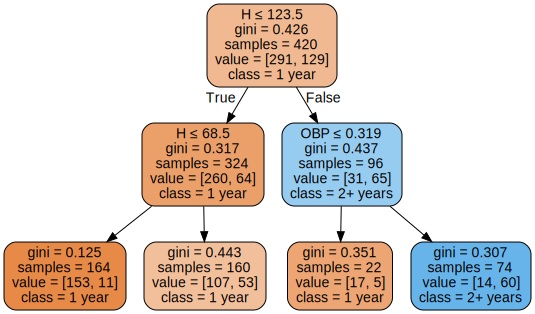

In [14]:
X = Batter[all_features_b]
y = Batter["Multiyear"]
X_train, X_test, y_train, y_test  =  train_test_split(X,y, test_size = 0.2, random_state = 1)

clf_CART = tree.DecisionTreeClassifier(max_depth = 2, random_state = 1)
clf_CART = clf_CART.fit(X_train, y_train)
y_pred_CART = clf_CART.predict(X_test)
y_pred_CART_train = clf_CART.predict(X_train)

cm_CART = confusion_matrix(y_test, y_pred_CART)
acc_CART = (cm_CART[0][0] + cm_CART[1][1]) / sum(sum(cm_CART))
cm_CART_train = confusion_matrix(y_train, y_pred_CART_train)
acc_CART_train = (cm_CART_train[0][0] + cm_CART_train[1][1]) / sum(sum(cm_CART_train))

print("CART Model using max_depth = 2")
print("===========================================")
print("CART Accuracy on the train set: {:.2%}".format(acc_CART_train))
print(cm_CART_train)
print("===========================================")
print("CART Accuracy on the test set: {:.2%}".format(acc_CART))
print(cm_CART)
print("===========================================")
print("Baseline accuracy is {0:.2%}".format(1 - np.mean(y_train)))
print("===========================================")

from tabulate import tabulate
print(tabulate([['', "", 'Predicted', 'Predicted'], ['','', "2+ years", "1 year"], ['Actual',"2+ years", "True Positive", "True Negative"], ['Actual', '1 year', 'False Positive', 'True Negative']]))


import graphviz 
dot_data = tree.export_graphviz(clf_CART, out_file=None, 
                                feature_names=all_features_b,  
                                class_names=["1 year", "2+ years"],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

I agree hits and on base percentage are good metrics for hitters, but I am surprised that the model can use such a simple tree to get a better prediction. For the data we have, if we are to maximise accuarcy, we will have to choose the model with two layers. However, if we are to make inference to see which variables contribute to a player signing multiyear contracts, it is better that we look deeper in the tree and see what other variables it uses.  <br>

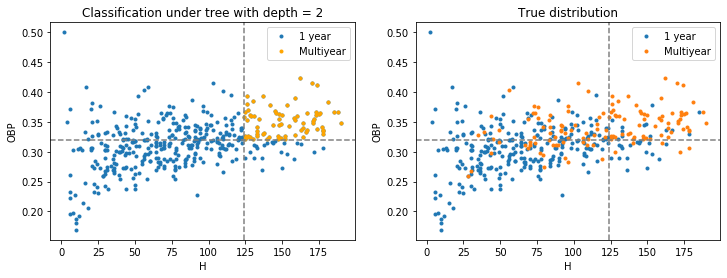

In [15]:
pd.options.mode.chained_assignment = None # suppress SettingWithCopyWarning

X_train_p = X_train[((X_train["H"]>=124) & (X_train["OBP"]>=0.319))]
X_train_g = X_train
X_train_g["Multiyear"] = y_train
groups = X_train_g.groupby("Multiyear")

fig, ax = plt.subplots(nrows = 1,ncols = 2, figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(X_train["H"], X_train["OBP"], ".", label = "1 year")
plt.plot(X_train_p["H"], X_train_p["OBP"], ".", color = "orange", label = "Multiyear")
# plt.axhline(y = (1 - np.mean(y_train)), ls = "--", label = "Baseline Accuracy", c = "grey") 
plt.axhline(y = 0.319, ls = "--", c = "grey")
plt.axvline(x = 124, ls = "--", c = "grey")
plt.title("Classification under tree with depth = 2")
plt.xlabel("H")
plt.ylabel("OBP")
plt.legend()

plt.subplot(1, 2, 2)


for name, group in groups:
    plt.plot(group["H"], group["OBP"], linestyle='', marker='.', label=name)
    
plt.plot()
plt.title("True distribution")
plt.axhline(y = 0.319, ls = "--", c = "grey")
plt.axvline(x = 124, ls = "--", c = "grey")
plt.xlabel("H")
plt.ylabel("OBP")
L=plt.legend()
L.get_texts()[0].set_text('1 year')
L.get_texts()[1].set_text('Multiyear')

A big drawback using the CART model is it hard cuts the data in a specific value. The data points near the criterion are often the ones easily mistaken. However, we can still see that the CART model does create a fairly accurate classification on the upper right hand side. 

# Tree with depth = 4

CART Model using max_depth = 4
CART Accuracy on the train set: 87.14%
[[279  12]
 [ 42  87]]
CART Accuracy on the test set: 72.64%
[[64 11]
 [18 13]]
Baseline accuracy is 69.29%


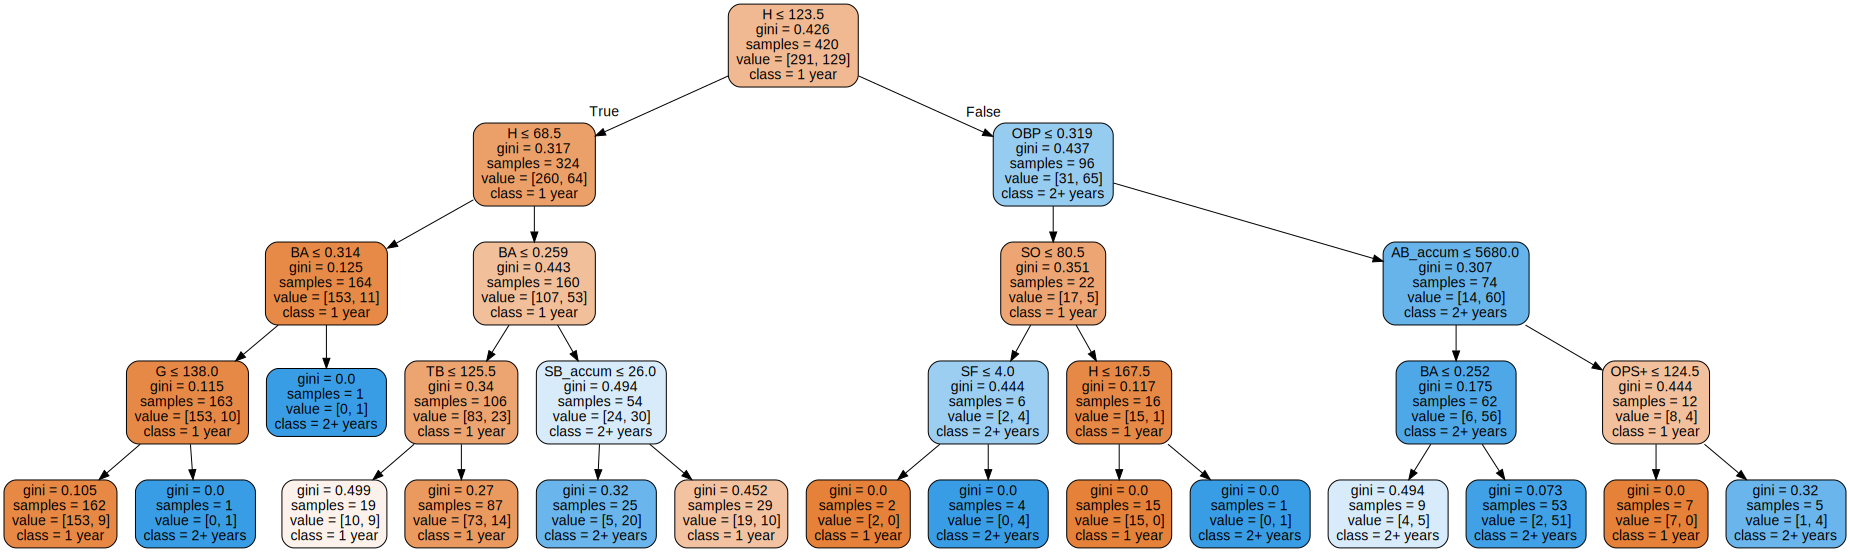

In [16]:
X = Batter[all_features_b]
y = Batter["Multiyear"]
X_train, X_test, y_train, y_test  =  train_test_split(X,y, test_size = 0.2, random_state = 1)

clf_CART = tree.DecisionTreeClassifier(max_depth = 4, random_state = 1)
clf_CART = clf_CART.fit(X_train, y_train)
y_pred_CART = clf_CART.predict(X_test)
y_pred_CART_train = clf_CART.predict(X_train)

cm_CART = confusion_matrix(y_test, y_pred_CART)
acc_CART = (cm_CART[0][0] + cm_CART[1][1]) / sum(sum(cm_CART))
cm_CART_train = confusion_matrix(y_train, y_pred_CART_train)
acc_CART_train = (cm_CART_train[0][0] + cm_CART_train[1][1]) / sum(sum(cm_CART_train))

print("CART Model using max_depth = 4")
print("===========================================")
print("CART Accuracy on the train set: {:.2%}".format(acc_CART_train))
print(cm_CART_train)
print("===========================================")
print("CART Accuracy on the test set: {:.2%}".format(acc_CART))
print(cm_CART)
print("===========================================")
print("Baseline accuracy is {0:.2%}".format(1 - np.mean(y_train)))
print("===========================================")

import graphviz 
dot_data = tree.export_graphviz(clf_CART, out_file=None, 
                                feature_names=all_features_b,  
                                class_names=["1 year", "2+ years"],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data) 
graph 

In [17]:
np.array(all_features_b)[[i for i, x in enumerate(clf_CART.feature_importances_) if x]]

array(['G', 'H', 'SO', 'BA', 'OBP', 'OPS+', 'TB', 'SF', 'AB_accum',
       'SB_accum'], dtype='<U9')

As we expected, the deeper we go down the tree, the more variables it uses. This time, it chose 10 variables: 'G', 'AB', 'H', 'BA', 'OBP', 'OPS+', 'SF', 'G_accum', '3B_accum', and 'GDP_accum'. The more hits you have, the higher the batting average, the more likely it is to get a multiyear contract, most variables make sense to me, except for 3B_accum and 'GDP_accum'.  <br>

However, when we look at the leaves, we see that some of them have a sample size of 1, which is also a sign of overfitting. The tree tries to fit perfectly into the training set. To prevent this we could use min_samples_leaf to control for the minimum size of each leaf. When min_samples_leaf increases, the number of variables picked will decrease. 

# Tree with depth = 4, min_sampels_leaf = 10

CART Model using max_depth = 4
CART Accuracy on the train set: 84.76%
[[280  11]
 [ 53  76]]
CART Accuracy on the test set: 75.47%
[[68  7]
 [19 12]]
Baseline accuracy is 69.29%


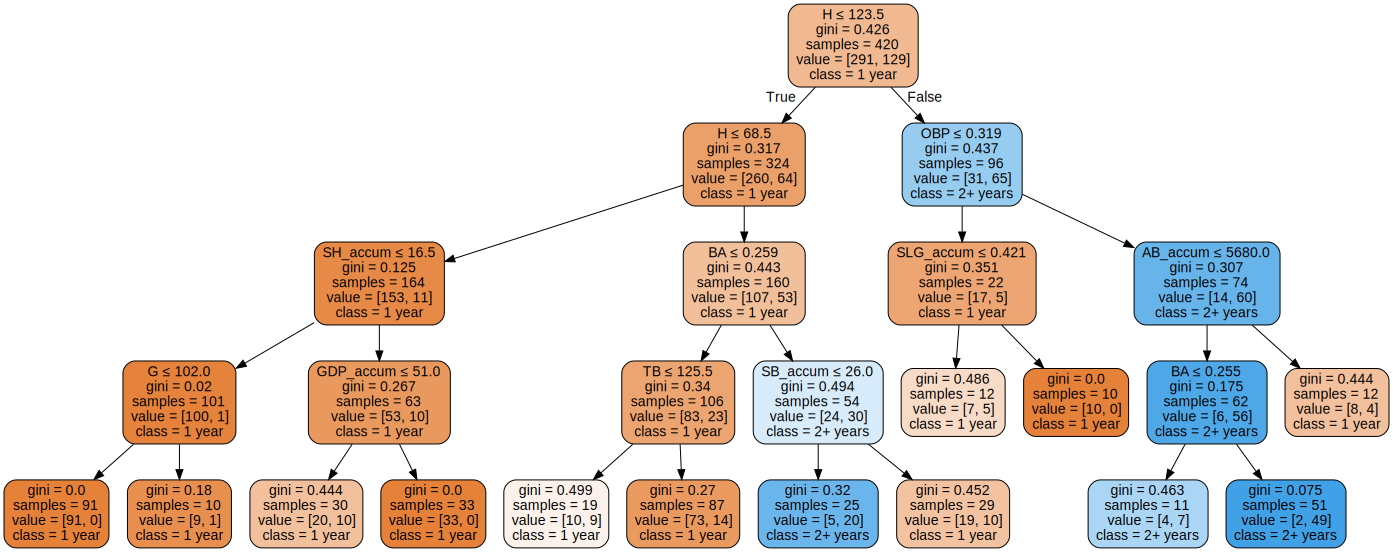

In [18]:
clf_CART = tree.DecisionTreeClassifier(max_depth = 4, random_state = 1, min_samples_leaf = 10)
clf_CART = clf_CART.fit(X_train, y_train)
y_pred_CART = clf_CART.predict(X_test)
y_pred_CART_train = clf_CART.predict(X_train)

cm_CART = confusion_matrix(y_test, y_pred_CART)
acc_CART = (cm_CART[0][0] + cm_CART[1][1]) / sum(sum(cm_CART))
cm_CART_train = confusion_matrix(y_train, y_pred_CART_train)
acc_CART_train = (cm_CART_train[0][0] + cm_CART_train[1][1]) / sum(sum(cm_CART_train))

print("CART Model using max_depth = 4")
print("===========================================")
print("CART Accuracy on the train set: {:.2%}".format(acc_CART_train))
print(cm_CART_train)
print("===========================================")
print("CART Accuracy on the test set: {:.2%}".format(acc_CART))
print(cm_CART)
print("===========================================")
print("Baseline accuracy is {0:.2%}".format(1 - np.mean(y_train)))
print("===========================================")

import graphviz 
dot_data = tree.export_graphviz(clf_CART, out_file=None, 
                                feature_names=all_features_b,  
                                class_names=["1 year", "2+ years"],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data) 
graph 

In [19]:
np.array(all_features_b)[[i for i, x in enumerate(clf_CART.feature_importances_) if x]]

array(['G', 'H', 'BA', 'OBP', 'TB', 'AB_accum', 'SB_accum', 'SLG_accum',
       'GDP_accum', 'SH_accum'], dtype='<U9')

The variables that the tree really uses are: H, OBP, SB_accum, AB_accum

When we increase the min_samples_leaf to 10, the testing accuracy increases. This is because the model now generalizes better comparing to min_samples_leaf = 1. The tree does not try to overfit the training data (the training accuracy decreases). 

# Logistic Regression

We can also use logisitc regression to predict a binary outcome.  <br>

A. Default solver

In [20]:
X = Batter[all_features_b]
y = Batter["Multiyear"]
X_train, X_test, y_train, y_test  =  train_test_split(X,y, test_size = 0.2, random_state = 1)

clf_lr = LogisticRegression(penalty = "l2", solver = "lbfgs", max_iter = 10000)
clf_lr = clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
y_pred_lr_train = clf_lr.predict(X_train)
cm_lr = confusion_matrix(y_true = y_test, y_pred = y_pred_lr, labels = [1,0])
acc_lr = (cm_lr[0][0] + cm_lr[1][1]) / sum(sum(cm_lr))
cm_lr_train = confusion_matrix(y_true = y_train, y_pred = y_pred_lr_train, labels = [1,0])
acc_lr_train = (cm_lr_train[0][0] + cm_lr_train[1][1]) / sum(sum(cm_lr_train))

print("Logistic Regression Accuracy on the train set: {:.2%}".format(acc_lr_train))
print(cm_lr_train)
print("===========================================")
print("Logistic Regression  Accuracy on the test set: {:.2%}".format(acc_lr))
print(cm_lr)
print("===========================================")
print("Baseline accuracy is {0:.2%}".format(1 - np.mean(y_train)))
print("===========================================")

from tabulate import tabulate
print(tabulate([['', "", 'Predicted', 'Predicted'], ['','', "2+ years", "1 year"], ['Actual',"2+ years", "True Positive", "True Negative"], ['Actual', '1 year', 'False Positive', 'True Negative']]))

print("===========================================")
print("Variables used in Logistic Regression:" ,[all_features_b[i] for i, x in enumerate((clf_lr.coef_ != 0).tolist()[0]) if x])
print("===========================================")
print("Variables not used in Logistic Regression:" ,[all_features_b[i] for i, x in enumerate((clf_lr.coef_ == 0).tolist()[0]) if x])

Logistic Regression Accuracy on the train set: 85.95%
[[ 88  41]
 [ 18 273]]
Logistic Regression  Accuracy on the test set: 74.53%
[[16 15]
 [12 63]]
Baseline accuracy is 69.29%
------  --------  --------------  -------------
                  Predicted       Predicted
                  2+ years        1 year
Actual  2+ years  True Positive   True Negative
Actual  1 year    False Positive  True Negative
------  --------  --------------  -------------
Variables used in Logistic Regression: ['Age', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'WAR', 'G_accum', 'PA_accum', 'AB_accum', 'R_accum', 'H_accum', '2B_accum', '3B_accum', 'HR_accum', 'RBI_accum', 'SB_accum', 'CS_accum', 'BB_accum', 'SO_accum', 'BA_accum', 'OBP_accum', 'SLG_accum', 'OPS_accum', 'TB_accum', 'GDP_accum', 'HBP_accum', 'SH_accum', 'SF_accum', '1B_accum', 'WAR_accum']
Variables not used in Logistic Regression: []


In [21]:
# Largest coefficients
print(pd.DataFrame(data = clf_lr.coef_[0].tolist(), index = all_features_b, columns = ["Coefficient"]).sort_values(by = "Coefficient", ascending=False).head())
# Smallest coefficients
print(pd.DataFrame(data = clf_lr.coef_[0].tolist(), index = all_features_b, columns = ["Coefficient"]).sort_values(by = "Coefficient", ascending=False).tail())

           Coefficient
WAR           0.231184
SH            0.148011
H             0.118421
SF_accum      0.088998
WAR_accum     0.086838
          Coefficient
PA_accum    -0.028175
Age         -0.079412
SF          -0.113276
3B          -0.160928
IBB         -0.183342


B. solver = liblinear

In [22]:
X = Batter[all_features_b]
y = Batter["Multiyear"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)

clf_lr = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 10000)
clf_lr = clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
y_pred_lr_train = clf_lr.predict(X_train)
cm_lr = confusion_matrix(y_true = y_test, y_pred = y_pred_lr, labels = [1,0])
acc_lr = (cm_lr[0][0] + cm_lr[1][1]) / sum(sum(cm_lr))
cm_lr_train = confusion_matrix(y_true = y_train, y_pred = y_pred_lr_train, labels = [1,0])
acc_lr_train = (cm_lr_train[0][0] + cm_lr_train[1][1]) / sum(sum(cm_lr_train))

print("Logistic Regression Accuracy on the train set: {:.2%}".format(acc_lr_train))
print(cm_lr_train)
print("===========================================")
print("Logistic Regression  Accuracy on the test set: {:.2%}".format(acc_lr))
print(cm_lr)
print("===========================================")
print("Baseline accuracy is {0:.2%}".format(1 - np.mean(y_train)))
print("===========================================")

from tabulate import tabulate
print(tabulate([['', "", 'Predicted', 'Predicted'], ['','', "2+ years", "1 year"], ['Actual',"2+ years", "True Positive", "True Negative"], ['Actual', '1 year', 'False Positive', 'True Negative']]))

print("===========================================")
print("Variables used in Logistic Regression:" ,[all_features_b[i] for i, x in enumerate((clf_lr.coef_ != 0).tolist()[0]) if x])
print("===========================================")
print("Variables not used in Logistic Regression:" ,[all_features_b[i] for i, x in enumerate((clf_lr.coef_ == 0).tolist()[0]) if x])

Logistic Regression Accuracy on the train set: 85.71%
[[ 88  41]
 [ 19 272]]
Logistic Regression  Accuracy on the test set: 74.53%
[[16 15]
 [12 63]]
Baseline accuracy is 69.29%
------  --------  --------------  -------------
                  Predicted       Predicted
                  2+ years        1 year
Actual  2+ years  True Positive   True Negative
Actual  1 year    False Positive  True Negative
------  --------  --------------  -------------
Variables used in Logistic Regression: ['Age', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'BB', 'SO', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'WAR', 'G_accum', 'PA_accum', 'AB_accum', 'R_accum', 'H_accum', '2B_accum', '3B_accum', 'HR_accum', 'RBI_accum', 'SB_accum', 'CS_accum', 'BB_accum', 'SO_accum', 'TB_accum', 'GDP_accum', 'HBP_accum', 'SH_accum', 'SF_accum', '1B_accum', 'WAR_accum']
Variables not used in Logistic Regression: ['CS', 'BA', 'OBP', 'SLG', 'OPS', 'BA_accum', 'OBP_accum', 'SLG_accum', 'OPS_accum']


In [23]:
# Largest coefficients
print(pd.DataFrame(data = clf_lr.coef_[0].tolist(), index = all_features_b, columns = ["Coefficient"]).sort_values(by = "Coefficient", ascending=False).head())
# Smallest coefficients
print(pd.DataFrame(data = clf_lr.coef_[0].tolist(), index = all_features_b, columns = ["Coefficient"]).sort_values(by = "Coefficient", ascending=False).tail())

           Coefficient
WAR           0.207947
SH            0.154145
H             0.091493
WAR_accum     0.087455
BB            0.072992
     Coefficient
HR     -0.032939
Age    -0.081564
SF     -0.084939
IBB    -0.167783
3B     -0.200416


The reason why BA, OBP, SLG and OPS are not used is becaue they can be calculated by other fields.
- BA = H/AB
- OBP = (H+BB)/AB
- SLG = (1B + 2B*2 + 3B*3 + 4*HR)/AB
- OPS = OBP + SLG   <br>


Moreover, I am not surprised that caught stealing got removed because it is not an important metric in determining a good hitter.  <br>

Another benefit for using logisitic regression is that you can see the coefficients for the different variables. It shows how each variable effect the outcome. For example, the coefficient of Age is -0.08159, meaning on average, the older you are, the less likely you are to get a multiyear contract. The coefficients also show the magnitude of the variables: the coefficients for WAR(0.2079) and WAR_accum(0.0874) are both positive, which makes sense because WAR is a strong indicator of how well a player is. A larger value in the WAR coefficient also indicates that the WAR in the previous season is a more important factor in signing multiyear contracts that the accumlated WAR in a player's career. 

# K-Fold

In [24]:
from sklearn.model_selection import KFold
k = 10   # k-fold
kf = KFold(n_splits=k, shuffle = True, random_state = 1)
kf.get_n_splits(X)
train_acc = []
test_acc  = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    clf_lr = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 10000)
    clf_lr = clf_lr.fit(X_train, y_train)
    y_pred_lr = clf_lr.predict(X_test)
    y_pred_lr_train = clf_lr.predict(X_train)

    cm_lr = confusion_matrix(y_true = y_test, y_pred = y_pred_lr, labels = [1,0])
    acc_lr = (cm_lr[0][0] + cm_lr[1][1]) / sum(sum(cm_lr))
    cm_lr_train = confusion_matrix(y_true = y_train, y_pred = y_pred_lr_train, labels = [1,0])
    acc_lr_train = (cm_lr_train[0][0] + cm_lr_train[1][1]) / sum(sum(cm_lr_train))
    train_acc.append(round(acc_lr_train, 4))
    test_acc.append(round(acc_lr, 4))


    
print("Train Acc in each fold:", ["{:.2%}".format(i) for i in train_acc])
print("Test Acc in each fold:", ["{:.2%}".format(i) for i in test_acc])
print("10-fold Test Accuracy: {:.2%}".format(np.mean(test_acc)))

Train Acc in each fold: ['83.93%', '84.36%', '85.41%', '83.72%', '83.09%', '84.36%', '83.54%', '84.81%', '83.54%', '84.18%']
Test Acc in each fold: ['84.91%', '73.58%', '75.47%', '86.79%', '79.25%', '73.58%', '84.62%', '75.00%', '82.69%', '78.85%']
10-fold Test Accuracy: 79.47%


# Things that I learn from this project

    1. Using both CART and logisitc regression can help better predict whether a player will sign a multiyear contract. The accuarcy of the baseline model is 69% where it predicts every hitter to sign a one-year deal. The 10 fold test accuracy is 75.65% for CART and 79.47% for logistic regression. 

    2. We have not done feature selection before the model building. Some of the variables are correlated and they might    change the regression results. We can use Lasso or stepwise regression to help find the optimal set of variables. 
    
    3. Use cross validation to better estimate the test accuracy (test errors) and help mitigate the impact of randomness in the train test split.

    4. It is easy to read and interpret a CART model. we see that H is the most important variable followed by OBP in determining a hitter signing a multiyear contract. The variables selected at the top is more important than the variables at   the bottom. However, one drawback of CART is that it splits the data using a hard cut. Say a player hits 123 hits in the previous season, which is close to the 124 benchmark, does he really belongs to the one-year contract group? There is no grey area between the lines and it becomes tricky when data is close to the line. 
    
    5. The coefficients from the logistic regression that help us understand not only the impact on contract signing but     also the magnitude of the impact. The coefficient of WAR is 0.2079 which is the largest among all coefficients, meaning     that it has the higher the WAR, the more likely it is to sign a long-term contract. The coefficient of H and H_accum are also fairly large, which supports the finding in CART. 
    The coefficient of SO is -0.008261. The more a player gets struck out in the previous season, the less likely it is for him to sign a multi-year contract.    And the impact of getting struck out in the previous season is larger than getting stuck out in the past seasons because the coefficient of SO_accum is larger (-0.000436). 
    
    6. There are still other factors that will affect the outcome of free agents signing that are not in the data. Such as  the competitiveness of the market in that year, the inclination of players and teams. Injuries can also play a huge      factor in free agent signing as well. But we can still have a peek into how the past performance of a given player      affects its value in free agency markets.

# Appendix and things that I tried but did not work

# Full table of coefficients in logistic regression

In [25]:
print(pd.DataFrame(data = clf_lr.coef_[0].tolist(), index = all_features_b, columns = ["Coefficient"]).sort_values(by = "Coefficient", ascending=False))

           Coefficient
WAR           0.190426
SH            0.165532
H             0.092193
CS            0.086458
WAR_accum     0.076754
SB            0.061105
BB            0.057271
SF_accum      0.046669
GDP           0.031628
TB            0.021553
R             0.011834
2B_accum      0.010539
OPS+          0.009184
G_accum       0.007725
SF            0.004757
HR_accum      0.001974
TB_accum      0.000122
BA_accum      0.000000
OBP_accum     0.000000
SLG_accum     0.000000
SLG           0.000000
OPS           0.000000
OBP           0.000000
BA            0.000000
OPS_accum     0.000000
HR            0.000000
3B_accum      0.000000
SO           -0.000049
PA_accum     -0.000402
AB_accum     -0.000474
H_accum      -0.000703
1B_accum     -0.001584
R_accum      -0.002036
BB_accum     -0.002326
SO_accum     -0.002485
HBP          -0.003443
CS_accum     -0.003445
HBP_accum    -0.003734
RBI_accum    -0.005529
SB_accum     -0.006673
G            -0.007569
2B           -0.008371
RBI        

# Correlation Matrix among all features

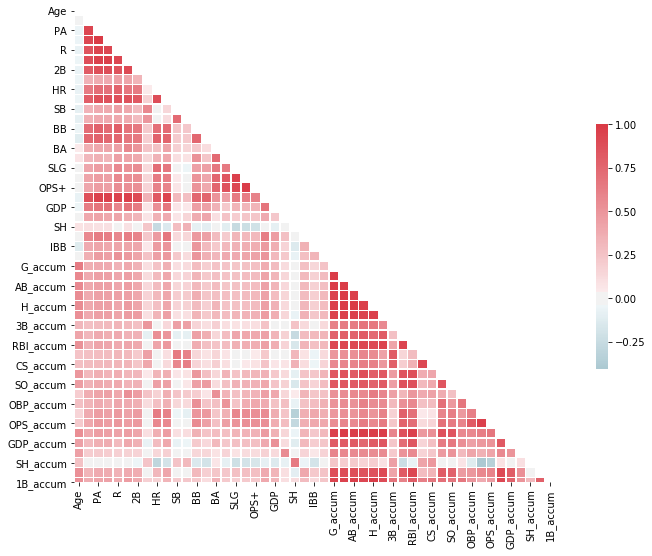

In [26]:
# Correlations of the features
corr = Batter[all_features_b].corr()
import seaborn as sns
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Use K-fold to find the optimal max_depth and min_samples_leaf

In [27]:
from sklearn.model_selection import KFold
k = 10   # k-fold
d = 10   # Max Depth
min_leaves = np.append(np.array([1]),(np.linspace(5,45,9)))
kf = KFold(n_splits=k, shuffle = True, random_state = 1)
kf.get_n_splits(X)
fold_train_acc = []
fold_test_acc = []
train_acc = []
test_acc  = []
max_depth = []
leaf_df = []
variables = []
variables_list = []
variables_list_2 = []

for j in min_leaves:
    for train_index, test_index in kf.split(X):
        for i in range(1, d+1):
            # print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
            y_train, y_test = y[train_index], y[test_index]

            clf_CART = tree.DecisionTreeClassifier(max_depth = i, random_state = 1, min_samples_leaf = int(j))
            clf_CART = clf_CART.fit(X_train, y_train)
            y_pred_CART = clf_CART.predict(X_test)
            y_pred_CART_train = clf_CART.predict(X_train)

            cm_CART = confusion_matrix(y_test, y_pred_CART)
            acc_CART = (cm_CART[0][0] + cm_CART[1][1]) / sum(sum(cm_CART))
            cm_CART_train = confusion_matrix(y_train, y_pred_CART_train)
            acc_CART_train = (cm_CART_train[0][0] + cm_CART_train[1][1]) / sum(sum(cm_CART_train))
            
            variables.append(np.array(all_features_b)[[i for i, x in enumerate(clf_CART.feature_importances_) if x]]) 
            train_acc.append(round(acc_CART_train, 4))
            test_acc.append(round(acc_CART, 4))
        fold_train_acc.append(train_acc)
        fold_test_acc.append(test_acc)
        train_acc = []
        test_acc  = []
        variables_list.append(variables)
        variables = []
        
    test_acc_df = pd.DataFrame(fold_test_acc)
    leaf_df.append(test_acc_df)
    fold_test_acc = []
    variables_list_2.append(variables_list)
    variables_list = []

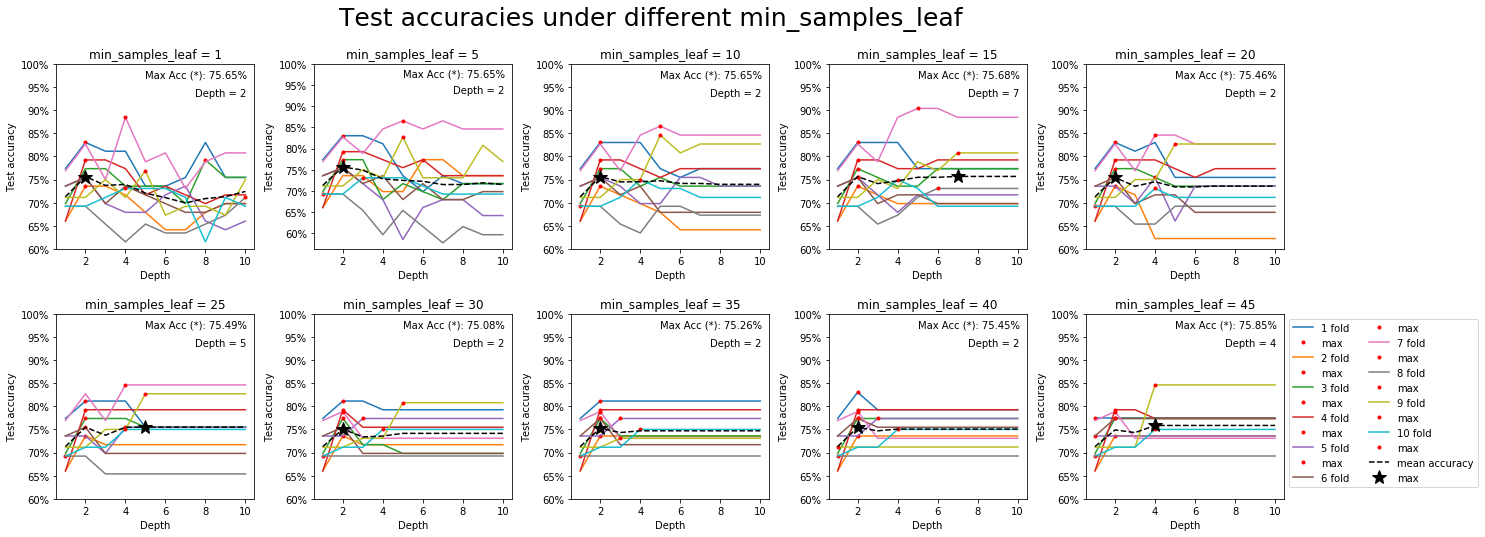

In [28]:
leaf_max = []
depth_mean_acc_list = []
fig, ax = plt.subplots(nrows = 2,ncols = 5,figsize=(22,8))
fig.suptitle(t = "Test accuracies under different min_samples_leaf", fontsize = 25)
plt.subplots_adjust(hspace = 0.35, wspace = 0.3)
for i, l in enumerate(min_leaves):
    plt.subplot(2, 5, i+1)
    depth_mean_acc = leaf_df[i].mean(axis = 0)
    depth_mean_acc_list.append(depth_mean_acc)
    test_acc_df = leaf_df[i]
    for j in range(k):
        row = test_acc_df.loc[j,:].tolist()
        plt.plot(np.linspace(1, d, d), row, label = "{} fold".format(j+1))
        plt.plot(row.index(max(row))+1, max(row), ".", color = "red", label = "max")
        max_depth.append(row.index(max(row))+1)
    

    plt.plot(np.linspace(1, d, d), depth_mean_acc, "--", label = "mean accuracy", color ="black")  # plot 10-fold average
    plt.plot(depth_mean_acc.tolist().index(max(depth_mean_acc))+1, max(depth_mean_acc), "*" ,color = "black", label = "max", markersize = 15)
    
    plt.yticks(ticks = np.linspace(0.6, 1, 9), labels = ["{0:.0%}".format(k) for k in np.linspace(0.6, 1, 9)])
    x = depth_mean_acc.tolist().index(max(depth_mean_acc))+1
    y = max(depth_mean_acc)
    plt.text(5, 0.97, s = "Max Acc (*): {0:.2%}".format(max(depth_mean_acc)))  # add text 
    plt.text(7.5, 0.93, s = "Depth = {}".format(x))                            # add text
    plt.title("min_samples_leaf = {}".format(int(l)))
    plt.xlabel("Depth")
    plt.ylabel("Test accuracy")
    leaf_max.append(max(depth_mean_acc))
plt.legend(ncol = 2, bbox_to_anchor=(1, 1))

The max accuracy does not change much using different min_samples_leaf.

## Number of variables picked under different min_samples_leaf

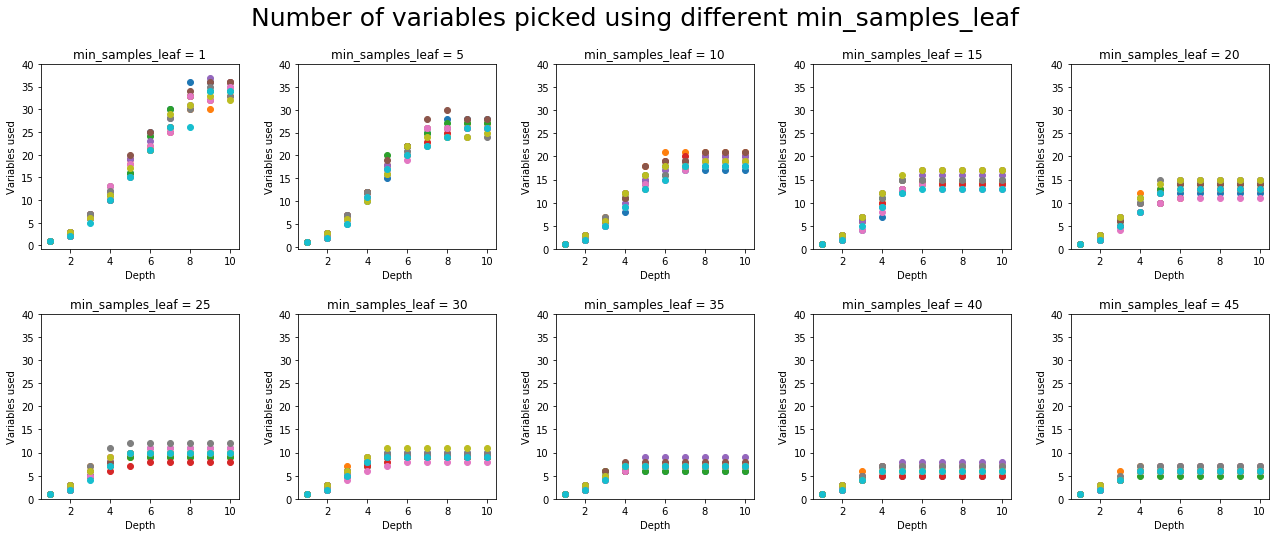

In [29]:
fig, ax = plt.subplots(nrows = 2,ncols = 5,figsize=(22,8))
fig.suptitle(t = "Number of variables picked using different min_samples_leaf", fontsize = 25)
plt.subplots_adjust(hspace = 0.35, wspace = 0.3)
for i, l in enumerate(min_leaves):
    plt.subplot(2, 5, i+1)
    for j in range(10):
        plt.plot(np.linspace(1, d, d), [len(k) for k in variables_list_2[i][j]], "o", label = "number of variables picked")
    plt.title("min_samples_leaf = {}".format(int(l)))
    plt.xlabel("Depth")
    plt.ylabel("Variables used")
    plt.yticks(ticks = np.linspace(0, 40, 9))

Increasing min_samples_leaf does not increase test accuracy. However, it reduces the number of variables picked by CART. Another thing that we can observe from the plot is that when we increase min_samples_leaf, it would be harder to split deeper. And now we have 1000 models (each dot is a CART model, with 10 different depth X 10 folds x 10 different leaves), let's see which variables are used the most.  

# Which variables got picked the most?

At each depth, summed by 10 folds

In [30]:
df = pd.DataFrame()
for k in range(10):   # Each depth
    a = Counter()      
    for i in range(10):      # Each leave 
        for j in range(10):  # Each fold
            a = a + Counter(variables_list_2[i][j][k])    # Counts number of time each variable gets picked 
    b = a.most_common(10)              # The top 10 most used variables in each depth
    c = pd.DataFrame(b, columns = ["Depth_{}".format(k+1), "Count_{}".format(k+1)])   # make data frame
    df = pd.concat([df, c], axis = 1)
df 

,Depth_1,Count_1,Depth_2,Count_2,Depth_3,Count_3,Depth_4,Count_4,Depth_5,Count_5,Depth_6,Count_6,Depth_7,Count_7,Depth_8,Count_8,Depth_9,Count_9,Depth_10,Count_10
0,H,40.0,H,70,H,100,H,100,H,100,H,100,H,100,H,100,H,100,H,100
1,OPS+,20.0,OPS,34,OBP,69,OBP,80,OBP,84,OBP,84,OBP,85,OBP,85,OBP,84,OBP,84
2,2B,20.0,OBP,30,BA,68,BA,69,BA,77,BA,76,BA,78,BA,78,BA,77,BA,77
3,BA,10.0,BA,30,OPS+,41,SH_accum,61,SH_accum,68,SH_accum,68,SH_accum,68,SH_accum,68,SH_accum,69,SH_accum,69
4,TB,10.0,OPS+,27,OPS,33,AB,58,AB,59,AB,62,AB,63,AB,63,AB,63,AB,63
5,NaN,NaN,2B,20,SH_accum,29,OPS+,42,OPS+,46,WAR,45,OPS+,50,WAR,52,WAR,51,WAR,52
6,NaN,NaN,BB,10,WAR,28,WAR,41,WAR,44,OPS+,45,WAR,49,OPS+,50,OPS+,50,OPS+,51
7,NaN,NaN,WAR,10,2B,28,OPS,38,2B,43,OPS,45,OPS,48,OPS,48,OPS,49,OPS,49
8,NaN,NaN,TB,10,SO_accum,17,2B,33,OPS,39,2B,44,2B,45,2B,45,SO_accum,45,2B,46
9,NaN,NaN,G_accum,5,HR_accum,14,HR_accum,25,SO_accum,38,SO_accum,44,SO_accum,43,SO_accum,44,2B,44,SO_accum,45


# Accuracy under different CART random_state

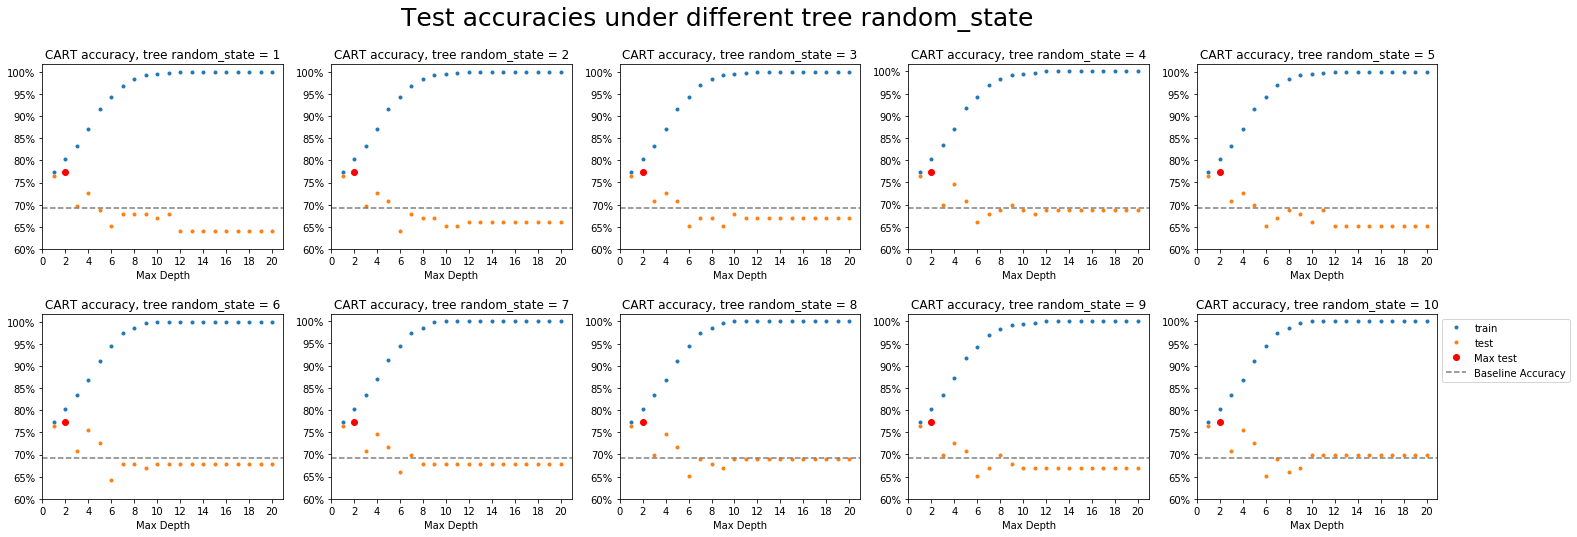

In [31]:
fig, ax = plt.subplots(nrows = 2,ncols = 5,figsize=(25,8))
fig.suptitle(t = "Test accuracies under different tree random_state", fontsize = 25)
plt.subplots_adjust(hspace = 0.35)  
X = Batter[all_features_b]
y = Batter["Multiyear"]
X_train, X_test, y_train, y_test  =  train_test_split(X,y, test_size = 0.2, random_state = 1)

train_acc = []
test_acc  = []
for k in range(10):
    for i in range(1, 21): 
        clf_CART = tree.DecisionTreeClassifier(max_depth = i, random_state = k)
        clf_CART = clf_CART.fit(X_train, y_train)
        y_pred_CART = clf_CART.predict(X_test)
        y_pred_CART_train = clf_CART.predict(X_train)

        cm_CART = confusion_matrix(y_test, y_pred_CART)
        acc_CART = (cm_CART[0][0] + cm_CART[1][1]) / sum(sum(cm_CART))
        cm_CART_train = confusion_matrix(y_train, y_pred_CART_train)
        acc_CART_train = (cm_CART_train[0][0] + cm_CART_train[1][1]) / sum(sum(cm_CART_train))
        train_acc.append(acc_CART_train)
        test_acc.append(acc_CART)
        
    plt.subplot(2, 5, k+1)

    plt.plot(np.linspace(1,20,20), train_acc, '.', label = "train")
    plt.plot(np.linspace(1,20,20), test_acc, '.',  label = "test")
    plt.plot(test_acc.index(max(test_acc)) + 1, max(test_acc), "o", color = "red", label = "Max test")
    plt.xticks(ticks = np.linspace(0, 20, 11))
    plt.yticks(ticks = np.linspace(0.6, 1, 9), labels = ["{0:.0%}".format(i) for i in np.linspace(0.6, 1, 9)])
    plt.axhline(y = (1 - np.mean(y_train)), ls = "--", label = "Baseline Accuracy", c = "grey")  # Basic Train accuracy 
    plt.title("CART accuracy, tree random_state = {}".format(k+1))
    plt.xlabel("Max Depth")
    train_acc = []
    test_acc  = []
plt.legend(bbox_to_anchor=(1, 1))

The random_state in CART does not affect the test accuracy as much. 